# World Air Quality Data 20 - Data Analysis

# World Air Quality Data 20

In [1]:
# Run this in a Jupyter notebook cell
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {
    'NotebookApp': {
        'iopub_data_rate_limit': 10000000
    }
})


# Importing the necessary libraries

In [2]:
# Importing the necessary libraries for data manipulation and visualization

# NumPy for numerical operations
import numpy as np

# Pandas for data manipulation and analysis
import pandas as pd

# Seaborn for statistical data visualization
import seaborn as sns

# Matplotlib for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plotly for interactive graphing
import plotly.express as px

# Bokeh for interactive visualizations
from bokeh.plotting import *
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS, Select, RadioButtonGroup, Div, HoverTool

# Folium for interactive maps
#import folium
#from folium import Choropleth, Circle, Marker
#from folium.plugins import HeatMap, MarkerCluster
#from folium.features import DivIcon

# IO and image processing libraries
import io
from PIL import Image, ImageDraw

# Selenium for web automation and testing
#import selenium

# Glob for file pattern matching
import glob

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None


# Load dataset || View 

In [3]:
df = pd.read_csv("world_air_quality.csv",sep=';')

In [4]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
# View few row and columns
df.head()

Country Code City           Location            Coordinates Pollutant  \
0           JP  NaN  北九州市小倉北区大門一丁目６－４８  33.880833, 130.873056        NO   
1           JP  NaN   北九州市若松区本町三丁目１３－１      33.898056, 130.81       NO2   
2           JP  NaN   北九州市門司区大里原町１２－１２  33.895833, 130.935833       NOX   
3           JP  NaN          千歳市若草４－１３     42.786944, 141.605       NO2   
4           JP  NaN    千葉市稲毛区宮野木町９９６－９  35.653889, 140.097778       NOX   

      Source Name Unit  Value               Last Updated Country Label  
0  japan-soramame  ppm  0.002  2024-03-10T13:30:00+05:30         Japan  
1  japan-soramame  ppm  0.005  2024-03-10T13:30:00+05:30         Japan  
2  japan-soramame  ppm  0.013  2024-03-10T13:30:00+05:30         Japan  
3  japan-soramame  ppm  0.004  2024-03-10T13:30:00+05:30         Japan  
4  japan-soramame  ppm  0.003  2024-03-10T13:30:00+05:30         Japan

# 1. Data Summary

In [6]:
print("Data Dimensions:")
print(df.shape)

Data Dimensions:
(54255, 10)


In [7]:
# Check data type
df.dtypes

Country Code      object
City              object
Location          object
Coordinates       object
Pollutant         object
Source Name       object
Unit              object
Value            float64
Last Updated      object
Country Label     object
dtype: object

In [8]:
print("Data Dimensions:")
print("Number of row :",df.shape[0])
print("Number of columns:",df.shape[1])


Data Dimensions:
Number of row : 54255
Number of columns: 10


In [9]:
print("\n Data information:")
df.info()


 Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54255 entries, 0 to 54254
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Code   54255 non-null  object 
 1   City           30209 non-null  object 
 2   Location       54253 non-null  object 
 3   Coordinates    54185 non-null  object 
 4   Pollutant      54255 non-null  object 
 5   Source Name    54255 non-null  object 
 6   Unit           54255 non-null  object 
 7   Value          54255 non-null  float64
 8   Last Updated   54255 non-null  object 
 9   Country Label  54140 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.1+ MB


In [10]:
print("\n Summary Statistics:")
df.describe()


 Summary Statistics:


Value
count  5.425500e+04
mean   6.290627e+02
std    2.927522e+04
min   -4.905140e+04
25%    2.125930e-01
50%    9.200000e+00
75%    3.253500e+01
max    3.198676e+06

# 2 -  Initial Analysis

In [11]:
# 1- There are values missing mainly on City (44%), but also a few on Coordinates, Location and Country Label
df.isna().sum()/len(df)

Country Code     0.000000
City             0.443203
Location         0.000037
Coordinates      0.001290
Pollutant        0.000000
Source Name      0.000000
Unit             0.000000
Value            0.000000
Last Updated     0.000000
Country Label    0.002120
dtype: float64

In [12]:
# 2- 131 countries, top ones are China (11k), Japan (6k), US (6k), Spain (3k) and France (2k)

# Group by 'Country Code' and count the number of 'Pollutant' records for each country
obs_country = df.groupby('Country Code')['Pollutant'].count().reset_index()

# Rename the 'Pollutant' column to 'Records'
obs_country = obs_country.rename(columns={"Pollutant":"Records"})

# Sort the DataFrame by the 'Records' column in descending order
obs_country_sorted = obs_country.sort_values('Records',ascending=False)

# Display the top countries with the most air quality records
print(obs_country_sorted.head(10))

    Country Code  Records
27            CN    11115
63            JP     6270
125           US     6051
40            ES     3251
43            FR     2490
57            IN     2367
34            DE     2223
60            IT     2166
119           TR     1694
130           ZA     1641


In [13]:
# 3- Countries with missing coordinates

missing_coord = df[df['Coordinates'].isna()].groupby('Country Code')['Pollutant'].count()\
                            .reset_index()\
                            .rename(columns={'Pollutant': 'Missing_Coord'})

missing_coord = missing_coord.merge(obs_country, how='left', on='Country Code')
missing_coord.assign(Missing_Perc = missing_coord.Missing_Coord / missing_coord.Records)

Country Code  Missing_Coord  Records  Missing_Perc
0           TR             22     1694      0.012987
1           US              6     6051      0.000992
2           ZA             42     1641      0.025594

In [14]:
# 4- Identify countries with missing 'Country Label
df[df['Country Label'].isna()].groupby('Country Code')['Pollutant'].count()

Country Code
AJ     7
AQ     7
BK     3
CE     1
CW     2
IZ     1
KU     1
KV     1
TI     1
TX     1
UC     2
VM     2
XK    86
Name: Pollutant, dtype: int64

In [15]:
# 5- different units, most used ones are µg/m³ and ppm
df.groupby('Unit')['Country Code'].count().sort_values(ascending=False)

Unit
µg/m³            40948
ppm              13059
c                  117
%                   66
particles/cm³       65
Name: Country Code, dtype: int64

In [16]:
# 6- different units, most used ones are µg/m³ and ppm
df.groupby(['Unit','Pollutant'])['Country Code'].count()

Unit           Pollutant       
%              RELATIVEHUMIDITY      66
c              TEMPERATURE          117
particles/cm³  UM003                 65
ppm            CO                  1275
               NO                  1984
               NO2                 2857
               NOX                 1896
               O3                  2827
               PM2.5                  6
               SO2                 2214
µg/m³          BC                   135
               CO                  3799
               NO                  1879
               NO2                 7085
               NOX                  119
               O3                  5523
               PM1                  124
               PM10                8050
               PM2.5               9541
               SO2                 4693
Name: Country Code, dtype: int64

In [17]:
# 7- Filter rows where the unit is either 'µg/m³' or 'ppm'
df[df['Unit'].isin(['µg/m³', 'ppm'])].pivot_table(index='Pollutant', columns='Unit', values='Value', aggfunc='count')

Unit          ppm   µg/m³
Pollutant                
BC            NaN   135.0
CO         1275.0  3799.0
NO         1984.0  1879.0
NO2        2857.0  7085.0
NOX        1896.0   119.0
O3         2827.0  5523.0
PM1           NaN   124.0
PM10          NaN  8050.0
PM2.5         6.0  9541.0
SO2        2214.0  4693.0

In [18]:
# 8- Filtered DataFrame with units 'µg/m³' and 'ppm', grouped by 'Unit' and 'Pollutant' ,escriptive statistics
df[df['Unit'].isin(['µg/m³', 'ppm'])].groupby(['Unit', 'Pollutant']).describe()

Value                                                     \
                  count         mean            std        min         25%   
Unit  Pollutant                                                              
ppm   CO         1275.0   -43.740220     686.825080  -9999.000    0.200000   
      NO         1984.0    -0.002310       0.226891     -9.999    0.000000   
      NO2        2857.0   -13.904754     373.950685  -9999.000    0.002000   
      NOX        1896.0     0.002650       0.232460     -9.999    0.002000   
      O3         2827.0   -10.968051     326.270460  -9999.000    0.021000   
      PM2.5         6.0     5.733333       2.724457      2.000    4.850000   
      SO2        2214.0   -22.544385     474.747617  -9999.000    0.000000   
µg/m³ BC          135.0     0.694467       0.876989     -0.670    0.249405   
      CO         3799.0  8713.557657  110318.605965 -49051.400  310.000000   
      NO         1879.0   -12.689329     150.350716   -999.000    1.000000   
      NO2        7085.0    13.940258      89.624136   -999.000    7.427900   
      NOX         119.0    31.895788      35.557868      1.000   10.000000   
      O3         5523.0    73.949322      84.553557   -999.000   35.000000   
      PM1         124.0    22.872146      25.095907      0.000    4.959375   
      PM10       8050.0    27.091551     309.129385  -9999.000   12.750000   
      PM2.5      9541.0     6.907407     298.533545  -9999.000    5.000000   
      SO2        4693.0     8.769167      58.154823   -999.000    2.280000   

                                                       
                        50%         75%           max  
Unit  Pollutant                                        
ppm   CO           0.300000    0.514285  1.242358e+03  
      NO           0.000500    0.001600  1.134400e+00  
      NO2          0.003200    0.008000  7.228910e+01  
      NOX          0.004000    0.008000  1.136300e+00  
      O3           0.038000    0.049000  1.300000e+01  
      PM2.5        5.650000    6.000000  1.040000e+01  
      SO2          0.001000    0.002061  4.918149e+01  
µg/m³ BC           0.437400    0.735725  5.417010e+00  
      CO         520.000000  800.000000  3.198676e+06  
      NO           2.000000    7.700000  3.777000e+02  
      NO2         14.968000   27.000000  1.010644e+03  
      NOX         22.000000   38.000000  2.326053e+02  
      O3          63.000000   96.000000  2.004076e+03  
      PM1         15.372569   29.476265  1.697768e+02  
      PM10        22.900000   40.022499  1.985000e+03  
      PM2.5       10.000000   20.000000  1.060000e+03  
      SO2          5.000000    8.000000  3.052620e+03

In [19]:
# 9- Count the number of unique units used in each country and display the top 20 countries with the most diverse unit usage
df.groupby(['Unit', 'Country Code'])['Pollutant'].count().reset_index().groupby('Country Code')['Unit'].count().sort_values(ascending=False).head(20)

Country Code
MX    5
TH    5
ID    5
CA    5
ES    4
BE    4
DE    4
CZ    4
FR    4
GB    4
GH    4
CH    4
SN    4
IT    4
NL    4
NZ    4
IN    3
LA    3
AR    3
AU    3
Name: Unit, dtype: int64

In [20]:
# 10- Even after excluding uncommon units specific to certain pollutants, we find that 33 countries still use both 'µg/m³' and 'ppm' units:
df[df['Unit'].isin(['µg/m³', 'ppm'])].groupby(['Unit', 'Country Code'])['Pollutant'].count()\
                            .reset_index()\
                            .groupby('Country Code')['Unit'].count()\
                            .reset_index().groupby('Unit').count().reset_index().groupby('Unit').count()

Country Code
Unit              
1                1
2                1

In [21]:
# 11- There are a total of 4,438 unique "Last Updated" values recorded between 2014 and 2024:
# Aggregate information about the "Last Updated" column
df['Last Updated'].agg(['count','nunique','min','max'])

count                          54255
nunique                         4438
min        2014-03-13T17:30:00+05:30
max        2024-03-25T14:30:00+05:30
Name: Last Updated, dtype: object

In [22]:
# 12-'Coordinates' and aggregate information about the 'Last Updated' column
update_coord= df.groupby('Coordinates')['Last Updated'].agg(['count','nunique','min','max']).sort_values('nunique')
update_coord

count  nunique  \
Coordinates                                                
39.580890000000004, 118.09279                 6        1   
42.392002, 2.8420997                          1        1   
42.4006, -76.6538                             1        1   
42.403964, -82.208306                         5        1   
42.404686999999996, 12.857794                 2        1   
42.40469999999999, -8.6703                    2        1   
42.4164, -83.9019                             1        1   
42.420126, 19.255149                          2        1   
42.430801, -83.000801                         2        1   
42.387222, -71.026111                         1        1   
42.434149, -123.348466                        1        1   
42.448087, 19.240889                          3        1   
42.452299, -73.239648                         2        1   
42.4631, -83.183296                           1        1   
42.465889, 18.764574                          3        1   
42.4669, -87.8103                             1        1   
42.46807, 21.460363                           6        1   
42.486668, -110.099167                        4        1   
42.4992, -79.32                               1        1   
42.4478, -73.2547                             1        1   
42.374167, 140.941944                         1        1   
42.373001, -109.563004                        4        1   
42.3631, -71.0542                             1        1   
42.31196, 2.2130551                           1        1   
42.312078, -83.103469                         3        1   
42.312078420999995, 2.214272866               1        1   
42.312158, -83.091943                         4        1   
42.31411, -122.87923                          1        1   
42.31470000000001, 118.93589999999999         6        1   
42.3225, 140.997778                           5        1   
42.3231, -83.0689                             1        1   
42.325197, -71.056056                         5        1   
42.327579, -96.368192                         1        1   
42.329399, -71.082497                         8        1   
42.33155, -122.880266                         1        1   
42.333083, -81.742889                         2        1   
42.335, -89.0381                              1        1   
42.336667, 141.016111                         4        1   
42.341944, 141.027222                         4        1   
42.3475, 141.031111                           1        1   
42.3489, -71.097702                           5        1   
42.349954, -71.059194                         1        1   
42.5014, -92.315804                           1        1   
42.3042, -83.1072                             3        1   
42.5047, -87.8111                             2        1   
42.516943999465, 1.56525                      1        1   
42.61033499999999, 23.032191                  2        1   
42.6116666594649, -6.64333333                 2        1   
42.612113, -71.307519                         5        1   
42.623225, -122.810158                        1        1   
42.625349, 20.891036                          6        1   
42.6255555494649, -6.52083333                 4        1   
42.6267, -71.3622                             1        1   
42.626944, 141.540833                         5        1   
42.607817, -113.786817                        1        1   
42.6425, -73.7547                             1        1   
42.6446972216871, 18.1226111111111            4        1   
42.646519, 21.133536                          6        1   
42.648872, 21.137121                          6        1   
42.65167, -111.61472                          1        1   
42.655488, 23.383270999999997                 5        1   
42.655959, 21.139953                          1        1   
42.659728, 21.083317                          6        1   
42.661995, 21.15055                           1        1   
42.6425, 141.853333                           4        1   
42.607575, -113.785297

In [23]:
# 13- Calculate the proportion of coordinates with different numbers of unique updates
update_coord.groupby('nunique')['min'].count()/len('update_coord')

nunique
1     868.000000
2     215.416667
3      56.166667
4      16.500000
5       4.750000
6       2.333333
7       0.250000
8       0.333333
9       0.250000
12      0.166667
13      0.083333
14      0.166667
16      0.083333
18      0.083333
19      0.083333
20      0.166667
26      0.166667
29      0.083333
30      0.083333
32      0.083333
35      0.166667
42      0.083333
Name: min, dtype: float64

In [24]:
# 14- Extract year from 'min' and 'max' columns
update_coord['year_min']=update_coord['min'].str[:4]
update_coord['year_max']=update_coord['max'].str[:4]

# Calculate the proportion of coordinates grouped by minimum and maximum update year
update_frequency = update_coord.groupby(['year_min','year_max'])['nunique'].count() / len(update_coord)

# Display the sorted frequency
print(update_frequency.sort_values(ascending=False))

year_min  year_max
2024      2024        0.401902
2023      2023        0.194909
2021      2021        0.135564
2022      2022        0.044116
2020      2020        0.038610
2019      2019        0.030674
2018      2018        0.023524
2016      2016        0.020735
2017      2017        0.020306
2022      2023        0.015945
2023      2024        0.013514
2022      2024        0.010439
2021      2024        0.007651
2020      2024        0.005291
2017      2024        0.005077
2018      2024        0.003790
2021      2023        0.003218
2019      2024        0.003146
2017      2023        0.002503
2018      2023        0.002145
2019      2020        0.001859
          2021        0.001859
2020      2023        0.001359
2016      2023        0.001287
2017      2018        0.001216
2016      2024        0.001216
2021      2022        0.001001
2019      2023        0.000858
2018      2019        0.000787
2016      2017        0.000715
2019      2022        0.000644
2016      2018      

In [25]:
# -15 Top Cities with Highest Pollution Levels
df.groupby('City')['Value'].mean().nlargest(10)

City
Kastamonu     178916.136111
Bilecik       123781.950250
Kırklareli    106598.496867
Gümüşhane      72325.787333
Edirne         62003.463200
Gaziantep      52121.659103
Kayseri        52063.165744
Çanakkale      51726.574741
İstanbul       47567.806398
Hatay          45279.248522
Name: Value, dtype: float64

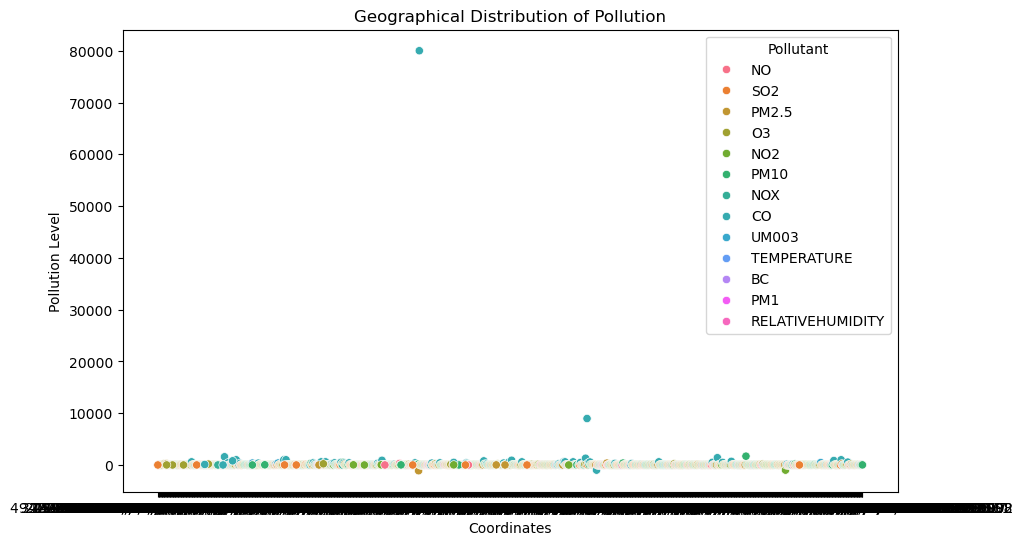

In [26]:
# Geographical Distribution of Pollution
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Coordinates', y='Value', hue='Pollutant', data=df.sample(1000))
plt.title('Geographical Distribution of Pollution')
plt.xlabel('Coordinates')
plt.ylabel('Pollution Level')
plt.show()


# 3- Cleaning the data

# Converting units

In [27]:
df.head()

Country Code City           Location            Coordinates Pollutant  \
0           JP  NaN  北九州市小倉北区大門一丁目６－４８  33.880833, 130.873056        NO   
1           JP  NaN   北九州市若松区本町三丁目１３－１      33.898056, 130.81       NO2   
2           JP  NaN   北九州市門司区大里原町１２－１２  33.895833, 130.935833       NOX   
3           JP  NaN          千歳市若草４－１３     42.786944, 141.605       NO2   
4           JP  NaN    千葉市稲毛区宮野木町９９６－９  35.653889, 140.097778       NOX   

      Source Name Unit  Value               Last Updated Country Label  
0  japan-soramame  ppm  0.002  2024-03-10T13:30:00+05:30         Japan  
1  japan-soramame  ppm  0.005  2024-03-10T13:30:00+05:30         Japan  
2  japan-soramame  ppm  0.013  2024-03-10T13:30:00+05:30         Japan  
3  japan-soramame  ppm  0.004  2024-03-10T13:30:00+05:30         Japan  
4  japan-soramame  ppm  0.003  2024-03-10T13:30:00+05:30         Japan

In [28]:
# Group by 'Country Code', count non-null values, and sort by 'Pollutant' in descending order
df.groupby('Country Code').count().sort_values('Pollutant',ascending =False)

City  Location  Coordinates  Pollutant  Source Name   Unit  \
Country Code                                                               
CN             109     11115        11115      11115        11115  11115   
JP               0      6270         6270       6270         6270   6270   
US            6026      6049         6045       6051         6051   6051   
ES            3132      3251         3251       3251         3251   3251   
FR            2103      2490         2490       2490         2490   2490   
IN               6      2367         2367       2367         2367   2367   
DE            2073      2223         2223       2223         2223   2223   
IT            1971      2166         2166       2166         2166   2166   
TR            1694      1694         1672       1694         1694   1694   
ZA            1629      1641         1599       1641         1641   1641   
MX            1232      1360         1360       1360         1360   1360   
PL             967      1219         1219       1219         1219   1219   
AT             880      1191         1191       1191         1191   1191   
CA             689      1064         1064       1064         1064   1064   
TH             638      1052         1052       1052         1052   1052   
GB             672       809          809        809          809    809   
AU             499       670          670        670          670    670   
TW             489       489          489        489          489    489   
CL             356       460          460        460          460    460   
IL               1       449          449        449          449    449   
CZ             390       446          446        446          446    446   
HU             390       437          437        437          437    437   
BE             381       437          437        437          437    437   
NL             322       370          370        370          370    370   
SE             311       340          340        340          340    340   
SK             308       313          313        313          313    313   
RS             298       298          298        298          298    298   
BR             223       261          261        261          261    261   
NO             182       217          217        217          217    217   
PT             206       206          206        206          206    206   
GR             183       183          183        183          183    183   
CO              40       162          162        162          162    162   
FI             138       157          157        157          157    157   
RU               1       151          151        151          151    151   
CH             116       148          148        148          148    148   
MK             144       144          144        144          144    144   
BG             141       141          141        141          141    141   
MN              64       140          140        140          140    140   
PE              88       119          119        119          119    119   
RO             114       114          114        114          114    114   
HK             101       101          101        101          101    101   
IE              85        91           91         91           91     91   
BA               5        87           87         87           87     87   
XK              86        86           86         86           86     86   
IS              72        80           80         80           80     80   
AE              76        80           80         80           80     80   
CY              78        78           78         78           78     78   
HR              62        68           68         68           68     68   
LT              63        63           63         63           63     63   
DK              36        45           45         45           45     45   
PS               0        44           44         44          

In [29]:
# Dictionary to convert pollutant concentration from ppm to µg/m³
dict_conv = {'CO': 1150, 'NO': 1230, 'NO2': 1880, 'O3': 1960, 'SO2': 2620, 'NOX': 1880}

# Apply the conversion factor from ppm to µg/m³ for applicable pollutants
df.loc[df['Unit'] == 'ppm', 'Conversion'] = df['Pollutant'].map(dict_conv)

# Convert values from ppm to µg/m³
df.loc[df['Unit'] == 'ppm','Value_standard'] = df['Conversion'] * df['Value']

# For values already in µg/m³, no conversion needed
df.loc[df['Unit'] == 'µg/m³', 'Value_standard'] =  df['Value']

In [30]:
# Checking if values seem okay
df.groupby(['Pollutant','Unit'])['Value_standard'].describe()

count          mean           std  \
Pollutant        Unit                                                
BC               µg/m³           135.0      0.694467  8.769887e-01   
CO               ppm            1275.0 -50301.252557  7.898488e+05   
                 µg/m³          3799.0   8713.557657  1.103186e+05   
NO               ppm            1984.0     -2.841437  2.790762e+02   
                 µg/m³          1879.0    -12.689329  1.503507e+02   
NO2              ppm            2857.0 -26140.937152  7.030273e+05   
                 µg/m³          7085.0     13.940258  8.962414e+01   
NOX              ppm            1896.0      4.982175  4.370253e+02   
                 µg/m³           119.0     31.895788  3.555787e+01   
O3               ppm            2827.0 -21497.380112  6.394901e+05   
                 µg/m³          5523.0     73.949322  8.455356e+01   
PM1              µg/m³           124.0     22.872146  2.509591e+01   
PM10             µg/m³          8050.0     27.091551  3.091294e+02   
PM2.5            ppm               0.0           NaN           NaN   
                 µg/m³          9541.0      6.907407  2.985335e+02   
RELATIVEHUMIDITY %                 0.0           NaN           NaN   
SO2              ppm            2214.0 -59066.289297  1.243839e+06   
                 µg/m³          4693.0      8.769167  5.815482e+01   
TEMPERATURE      c                 0.0           NaN           NaN   
UM003            particles/cm³     0.0           NaN           NaN   

                                        min         25%         50%  \
Pollutant        Unit                                                 
BC               µg/m³                -0.67    0.249405    0.437400   
CO               ppm           -11498850.00  230.000000  345.000000   
                 µg/m³            -49051.40  310.000000  520.000000   
NO               ppm              -12298.77    0.000000    0.615000   
                 µg/m³              -999.00    1.000000    2.000000   
NO2              ppm           -18798120.00    3.760000    6.016000   
                 µg/m³              -999.00    7.427900   14.968000   
NOX              ppm              -18798.12    3.760000    7.520000   
                 µg/m³                 1.00   10.000000   22.000000   
O3               ppm           -19598040.00   41.160000   74.480000   
                 µg/m³              -999.00   35.000000   63.000000   
PM1              µg/m³                 0.00    4.959375   15.372569   
PM10             µg/m³             -9999.00   12.750000   22.900000   
PM2.5            ppm                    NaN         NaN         NaN   
                 µg/m³             -9999.00    5.000000   10.000000   
RELATIVEHUMIDITY %                      NaN         NaN         NaN   
SO2              ppm           -26197380.00    0.000000    2.620000   
                 µg/m³              -999.00    2.280000    5.000000   
TEMPERATURE      c                      NaN         NaN         NaN   
UM003            particles/cm³          NaN         NaN         NaN   

                                       75%           max  
Pollutant        Unit                                     
BC               µg/m³            0.735725  5.417010e+00  
CO               ppm            591.427750  1.428712e+06  
                 µg/m³          800.000000  3.198676e+06  
NO               ppm              1.968000  1.395312e+03  
                 µg/m³            7.700000  3.777000e+02  
NO2              ppm             15.040000  1.359035e+05  
                 µg/m³           27.000000  1.010644e+03  
NOX              ppm             15.040000  2.136244e+03  
                 µg/m³           38.000000  2.326053e+02  
O3               ppm             96.040000  2.548000e+04  
                 µg/m³           96.000000  2.004076e+03  
PM1              µg/m³           29.476265  1.697768e+02  
PM10             µg/m³           40.022499  1.985000e+03  
PM2.5            ppm                   NaN  

In [31]:
# Count negative 'Value_standard' values by 'Pollutant'
negatives = df[df['Value_standard'] < 0].groupby('Pollutant').size().reset_index(name ='negatives ')

# Count the total occurences of each 'Pollutant'
total_counts = df.groupby('Pollutant').size().reset_index(name='count')

# Merage the counts of negative and total counts 
result = negatives.merge(total_counts, on='Pollutant')

# Display result
result

Pollutant  negatives   count
0        BC           2    135
1        CO          20   5074
2        NO          91   3863
3       NO2          88   9942
4       NOX           6   2015
5        O3          31   8350
6      PM10          45   8050
7     PM2.5         149   9547
8       SO2         116   6907

In [32]:
# Drop rows where 'Value_standard' is less than 0
df = df[df['Value_standard'] >= 0]

In [33]:
# Checking if values seem okay now
df.groupby(['Pollutant','Unit'])['Value_standard'].describe()

count         mean            std  min         25%  \
Pollutant Unit                                                         
BC        µg/m³   133.0     0.710173       0.873174  0.0    0.259460   
CO        ppm    1267.0  3836.769408   60704.296449  0.0  230.000000   
          µg/m³  3787.0  8756.199020  110488.127521  0.0  311.371247   
NO        ppm    1958.0     3.922638      35.180167  0.0    0.000000   
          µg/m³  1814.0     9.907419      23.275939  0.0    1.000000   
NO2       ppm    2831.0   187.579022    3991.596017  0.0    3.760000   
          µg/m³  7023.0    21.168563      28.195973  0.0    7.653142   
NOX       ppm    1890.0    15.779477      57.703906  0.0    3.760000   
          µg/m³   119.0    31.895788      35.557868  1.0   10.000000   
O3        ppm    2813.0    80.722514     481.421994  0.0   43.120000   
          µg/m³  5506.0    76.173312      69.753614  0.0   35.307075   
PM1       µg/m³   124.0    22.872146      25.095907  0.0    4.959375   
PM10      µg/m³  8005.0    38.792131      71.634707  0.0   13.000000   
PM2.5     µg/m³  9392.0    19.001467      40.343102  0.0    5.000000   
SO2       ppm    2148.0   125.116261    2954.193809  0.0    0.186020   
          µg/m³  4643.0     9.314839      54.583290  0.0    2.400000   

                        50%         75%           max  
Pollutant Unit                                         
BC        µg/m³    0.442730    0.745360  5.417010e+00  
CO        ppm    345.000000  597.085750  1.428712e+06  
          µg/m³  529.085040  800.000000  3.198676e+06  
NO        ppm      0.731235    2.110065  1.395312e+03  
          µg/m³    2.200000    8.200000  3.777000e+02  
NO2       ppm      6.563080   15.040000  1.359035e+05  
          µg/m³   15.000000   27.000000  1.010644e+03  
NOX       ppm      7.520000   15.040000  2.136244e+03  
          µg/m³   22.000000   38.000000  2.326053e+02  
O3        ppm     74.480000   96.040000  2.548000e+04  
          µg/m³   63.082000   96.000000  2.004076e+03  
PM1       µg/m³   15.372569   29.476265  1.697768e+02  
PM10      µg/m³   23.000000   40.500000  1.985000e+03  
PM2.5     µg/m³   10.400000   20.000000  1.060000e+03  
SO2       ppm      2.620000    5.662475  1.288555e+05  
          µg/m³    5.000000    8.000000  3.052620e+03

# Pollution levels

In [34]:
# Define good pollution levels for various pollutants
pol_levels_good = {
    'CO': 4,
    'NO2': 25,
    'O3': 100,
    'SO2': 40,
    'PM2.5': 15,
    'PM10': 45
}

# Define bad pollution levels for various pollutants
pol_levels_bad = {
    'CO': 7,
    'NO2': 120,
    'O3': 160,
    'SO2': 125,
    'PM2.5': 75,
    'PM10': 150
}

In [35]:
# Map good and bad pollution thresholds to each pollutant
df['Good_threshold'] = df['Pollutant'].map(pol_levels_good)
df['Bad_threshold'] = df['Pollutant'].map(pol_levels_bad)

# Categorize air quality based on pollution thresholds
df['Quality'] = 'Regular' # Default value
df.loc[df['Value_standard'] <= df['Good_threshold'],'Quality'] = 'Good'
df.loc[df['Value_standard'] <= df['Bad_threshold'],'Quality'] = 'Bad'

In [36]:
# Create a pivot table to count occurrences of each pollutant by quality
df.pivot_table(index='Pollutant', columns = 'Quality', values ='Value_standard',aggfunc='count')

Quality       Bad  Regular
Pollutant                 
BC            NaN    133.0
CO          179.0   4875.0
NO            NaN   3772.0
NO2        9811.0     43.0
NOX           NaN   2009.0
O3         7688.0    631.0
PM1           NaN    124.0
PM10       7743.0    262.0
PM2.5      9076.0    316.0
SO2        6735.0     56.0

# Coordinates

In [37]:
df.head()

Country Code City           Location            Coordinates Pollutant  \
0           JP  NaN  北九州市小倉北区大門一丁目６－４８  33.880833, 130.873056        NO   
1           JP  NaN   北九州市若松区本町三丁目１３－１      33.898056, 130.81       NO2   
2           JP  NaN   北九州市門司区大里原町１２－１２  33.895833, 130.935833       NOX   
3           JP  NaN          千歳市若草４－１３     42.786944, 141.605       NO2   
4           JP  NaN    千葉市稲毛区宮野木町９９６－９  35.653889, 140.097778       NOX   

      Source Name Unit  Value               Last Updated Country Label  \
0  japan-soramame  ppm  0.002  2024-03-10T13:30:00+05:30         Japan   
1  japan-soramame  ppm  0.005  2024-03-10T13:30:00+05:30         Japan   
2  japan-soramame  ppm  0.013  2024-03-10T13:30:00+05:30         Japan   
3  japan-soramame  ppm  0.004  2024-03-10T13:30:00+05:30         Japan   
4  japan-soramame  ppm  0.003  2024-03-10T13:30:00+05:30         Japan   

   Conversion  Value_standard  Good_threshold  Bad_threshold  Quality  
0      1230.0            2.46             NaN            NaN  Regular  
1      1880.0            9.40            25.0          120.0      Bad  
2      1880.0           24.44             NaN            NaN  Regular  
3      1880.0            7.52            25.0          120.0      Bad  
4      1880.0            5.64             NaN            NaN  Regular

In [38]:
# Split the 'Coordinates' column into 'Latitude' and 'Longitude' using ', ' as the separator
df[['Latitude', 'Longitude']] = df['Coordinates'].str.split(', ', expand=True)


# Convert 'Latitude' and 'Longitude' columns to float data type
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

# Drop rows with missing values in 'Latitude' or 'Longitude'
df = df.dropna(subset =['Latitude' ,'Longitude'])

In [39]:
# Group by 'Country Code', calculate count, minimum, and maximum latitude and longitude
result = df.groupby('Country Code')[['Latitude','Longitude']].agg(['count','min','max'])

# Sort the result by count of latitude in descending order
result = result.sort_values(('Latitude', 'count'),ascending=False)

result

Latitude                       Longitude                        
                count        min        max     count         min         max
Country Code                                                                 
CN              11113  18.248900  50.427800     11113   75.953800  131.165200
JP               6269  31.358611  43.810278      6269  129.667778  143.889722
US               5897   0.410931  70.131900      5897 -161.767000   82.795356
ES               3245  36.112824  43.570500      3245   -9.186100    2.842100
FR               2448   4.848160  51.052073      2448  -52.646490    9.475972
IN               2361   8.816428  34.066206      2361   72.456691   94.636574
DE               2191  47.518013  54.781430      2191    6.195834   14.973958
IT               2156  36.917119  46.797350      2156    6.835900   18.176670
TR               1664  36.081469  42.094952      1664   26.234100   44.625607
ZA               1541 -34.433361 -23.656028      1541   17.944911   32.078620
MX               1353  16.699340  32.646944      1353 -116.976944  -89.624811
PL               1218  49.293564  54.754139      1218   14.257407   23.642153
AT               1186  46.556930  48.878611      1186    9.596702   16.961091
CA               1008  42.333083  63.508600      1008 -135.058750  -52.711500
TH                964   6.426853  19.909217       964   97.917778  104.846219
GB                787  50.371670  57.734456       787   -7.331179    1.463497
AU                641 -43.170000 -16.961620       641  137.533239  153.402400
TW                489  21.958069  26.160469       489  118.312256  121.792928
CL                458 -53.158295 -18.476839       458  -73.331626  -68.648661
IL                442  30.985010  32.915750       442   34.542110   35.397640
CZ                439  48.791767  50.972167       439   12.363442   18.677799
HU                437  46.040885  48.473889       437   16.274910   21.705839
BE                423  49.719281  51.327659       423    2.582323    6.095760
SE                335  55.372875  67.878891       335   11.391136   21.479167
SK                311  47.959448  49.435380       311   17.019722   22.273666
RS                297  42.551125  45.821483       297   19.214534   22.592406
BR                261 -23.981295 -20.784689       261  -51.408777  -43.179500
NL                226  50.888000  53.330400       226    3.916620    6.932430
NO                215  58.388460  78.906690       215    5.236860   30.421470
PT                206  37.015000  42.181428       206   -9.429444   -7.301944
GR                183  37.901308  40.739842       183   21.734512   23.879026
FI                157  60.169640  68.477010       157   21.604070   29.401570
RU                151  50.234100  63.143100       151   22.332173  127.529100
CO                146   4.531206   6.436960       146  -75.644356  -74.031990
MK                143  41.030280  42.153961       143   20.698900   22.852709
BG                141  41.576623  43.851367       141   23.032191   27.935960
MN                140  43.567611  50.239694       140   89.964944  114.537583
CH                139  46.139000  47.594913       139    6.622300    9.394380
PE                118 -12.166389 -11.863253       118  -77.084472  -76.838289
RO                114  43.912880  47.953181       114   20.736851   28.787412
HK                101  22.247430  22.496710       101  113.943611  114.360833
IE                 88  51.855000  54.439510        88   -9.299722   -6.121667
BA                 87  43.661000  44.916000        87   17.185556   18.977000
XK                 86  42.153961  42.891794        86   20.284598   21.460363
AE                 78  23.095690  25.258481        78   52.754790   55.765790
CY                 78  34.686111  35.151944        78   33.035556   33.977735
IS                 75  63.985000  66.079276        75  -22.583994  -14.047610
HR                 66  42.644697  46.282911        66   13.749778   18.834639
LT                 63  54.092499  5

# Timestamps

In [40]:
# Convert the 'Last Updated' column in the DataFrame to datetime format
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

In [41]:
# Extract and create new columns for year, month, day, hour, year-month, and date from 'Last Updated'
df['Year'] = df['Last Updated'].dt.year
df['Month'] = df['Last Updated'].dt.month
df['Day'] = df['Last Updated'].dt.day
df['Hour'] = df['Last Updated'].dt.hour
df['Year-Month'] = df['Last Updated'].map(lambda x: x.strftime('%Y-%m'))
df['Date'] = df['Last Updated'].map(lambda x: x.strftime('%Y-%m-%d'))

In [42]:
df.columns

Index(['Country Code', 'City', 'Location', 'Coordinates', 'Pollutant',
       'Source Name', 'Unit', 'Value', 'Last Updated', 'Country Label',
       'Conversion', 'Value_standard', 'Good_threshold', 'Bad_threshold',
       'Quality', 'Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Hour',
       'Year-Month', 'Date'],
      dtype='object')

In [43]:
df.head()

Country Code City           Location            Coordinates Pollutant  \
0           JP  NaN  北九州市小倉北区大門一丁目６－４８  33.880833, 130.873056        NO   
1           JP  NaN   北九州市若松区本町三丁目１３－１      33.898056, 130.81       NO2   
2           JP  NaN   北九州市門司区大里原町１２－１２  33.895833, 130.935833       NOX   
3           JP  NaN          千歳市若草４－１３     42.786944, 141.605       NO2   
4           JP  NaN    千葉市稲毛区宮野木町９９６－９  35.653889, 140.097778       NOX   

      Source Name Unit  Value              Last Updated Country Label  \
0  japan-soramame  ppm  0.002 2024-03-10 13:30:00+05:30         Japan   
1  japan-soramame  ppm  0.005 2024-03-10 13:30:00+05:30         Japan   
2  japan-soramame  ppm  0.013 2024-03-10 13:30:00+05:30         Japan   
3  japan-soramame  ppm  0.004 2024-03-10 13:30:00+05:30         Japan   
4  japan-soramame  ppm  0.003 2024-03-10 13:30:00+05:30         Japan   

   Conversion  Value_standard  Good_threshold  Bad_threshold  Quality  \
0      1230.0            2.46             NaN            NaN  Regular   
1      1880.0            9.40            25.0          120.0      Bad   
2      1880.0           24.44             NaN            NaN  Regular   
3      1880.0            7.52            25.0          120.0      Bad   
4      1880.0            5.64             NaN            NaN  Regular   

    Latitude   Longitude  Year  Month  Day  Hour Year-Month        Date  
0  33.880833  130.873056  2024      3   10    13    2024-03  2024-03-10  
1  33.898056  130.810000  2024      3   10    13    2024-03  2024-03-10  
2  33.895833  130.935833  2024      3   10    13    2024-03  2024-03-10  
3  42.786944  141.605000  2024      3   10    13    2024-03  2024-03-10  
4  35.653889  140.097778  2024      3   10    13    2024-03  2024-03-10

# Changing format

In [44]:
# Define the index columns for the pivot table
index = [
    'Country Code', 
    'Source Name', 
    'Last Updated', 
    'Latitude', 
    'Longitude', 
    'Year', 
    'Month', 
    'Day', 
    'Hour', 
    'Year-Month', 
    'Date'
]

# Create a pivot table with the specified index and 'Pollutant' as columns, 
# aggregating 'Value_standard' using the max function
df_pivot = df.pivot_table(index=index, columns='Pollutant', values='Value_standard', aggfunc='max').reset_index()

# Create a second index for the pivot table excluding 'Hour' and 'Last Updated'
index_date = [col for col in index if col not in ['Hour', 'Last Updated']]

# Create a second pivot table with the modified index
df_pivot_date = df.pivot_table(index=index_date, columns='Pollutant', values='Value_standard', aggfunc='max').reset_index()


In [45]:
# Calculate the proportion of missing values for each column in the pivot table
missing_proportions = df_pivot.isna().sum() / len(df_pivot)
print(missing_proportions)

Pollutant
Country Code    0.000000
Source Name     0.000000
Last Updated    0.000000
Latitude        0.000000
Longitude       0.000000
Year            0.000000
Month           0.000000
Day             0.000000
Hour            0.000000
Year-Month      0.000000
Date            0.000000
BC              0.993052
CO              0.736287
NO              0.803103
NO2             0.485999
NOX             0.895152
O3              0.565824
PM1             0.993522
PM10            0.583325
PM2.5           0.510918
SO2             0.647320
dtype: float64


In [46]:
# Calculate the proportion of missing values for each column in the df_pivot_date DataFrame
missing_proportions_date = df_pivot_date.isna().sum() / len(df_pivot_date)
print(missing_proportions_date)

Pollutant
Country Code    0.000000
Source Name     0.000000
Latitude        0.000000
Longitude       0.000000
Year            0.000000
Month           0.000000
Day             0.000000
Year-Month      0.000000
Date            0.000000
BC              0.992361
CO              0.710741
NO              0.784204
NO2             0.437220
NOX             0.885468
O3              0.528030
PM1             0.993337
PM10            0.547099
PM2.5           0.475531
SO2             0.616083
dtype: float64


# Correlation analysis

Key findings: 
There are some very strong correlations, but they involve pollutants with very few observations (PM1 with 99% missing, BC with 99% missing, NOX with 88% missing)
When we leave these out, the strongest correlation is between PM2.5 and PM10 (74%)
There also isn't any strong correlation with pollution levels and coordinates or any time component

<Axes: xlabel='Pollutant', ylabel='Pollutant'>

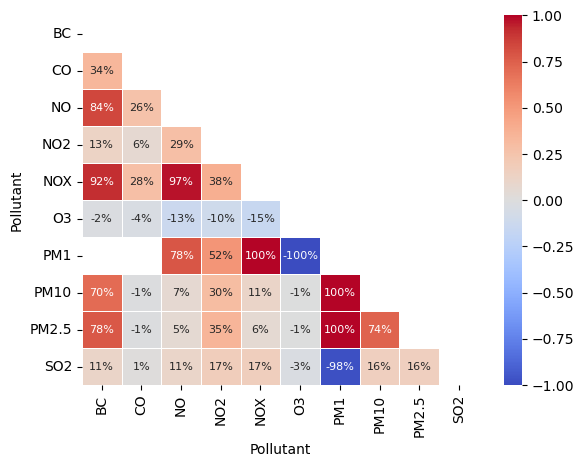

In [47]:
corr_pollutants = df_pivot[['BC', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM1', 'PM10', 'PM2.5', 'SO2']].corr(numeric_only=True)
np.fill_diagonal(corr_pollutants.values, np.nan)
matrix = np.triu(corr_pollutants)
sns.heatmap(corr_pollutants, annot=True,fmt='.0%',annot_kws ={"size" :8},linewidth=.5,cmap="coolwarm",mask=matrix)

<Axes: xlabel='Pollutant', ylabel='Pollutant'>

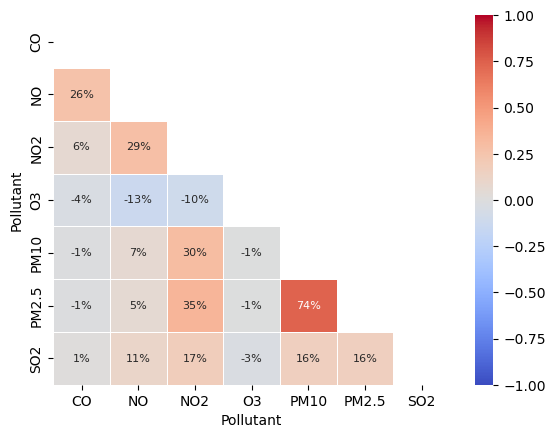

In [48]:
corr_pollutants = df_pivot[['CO', 'NO', 'NO2', 'O3', 'PM10', 'PM2.5', 'SO2']].corr(numeric_only=True)
np.fill_diagonal(corr_pollutants.values,np.nan)
matrix = np.triu(corr_pollutants)
sns.heatmap(corr_pollutants, annot=True,fmt='.0%',annot_kws={"size": 8},linewidth =.5,cmap='coolwarm',mask=matrix,vmin=-1, vmax=1)

<Axes: xlabel='Pollutant', ylabel='Pollutant'>

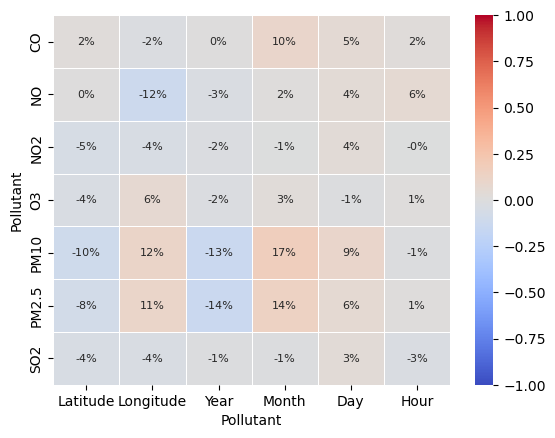

In [49]:
corr_others = df_pivot.corr(numeric_only=True)[['Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Hour']]
corr_others = corr_others[~corr_others.index.isin(['Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Hour', 'BC', 'NOX', 'PM1'])]
sns.heatmap(corr_others,annot=True,fmt='.0%',annot_kws={"size": 8},linewidth=.5,cmap='coolwarm',vmin=-1,vmax=1)

# Analysing data for a Pollutant 

In [52]:
df.head()


Country Code City           Location            Coordinates Pollutant  \
0           JP  NaN  北九州市小倉北区大門一丁目６－４８  33.880833, 130.873056        NO   
1           JP  NaN   北九州市若松区本町三丁目１３－１      33.898056, 130.81       NO2   
2           JP  NaN   北九州市門司区大里原町１２－１２  33.895833, 130.935833       NOX   
3           JP  NaN          千歳市若草４－１３     42.786944, 141.605       NO2   
4           JP  NaN    千葉市稲毛区宮野木町９９６－９  35.653889, 140.097778       NOX   

      Source Name Unit  Value              Last Updated Country Label  \
0  japan-soramame  ppm  0.002 2024-03-10 13:30:00+05:30         Japan   
1  japan-soramame  ppm  0.005 2024-03-10 13:30:00+05:30         Japan   
2  japan-soramame  ppm  0.013 2024-03-10 13:30:00+05:30         Japan   
3  japan-soramame  ppm  0.004 2024-03-10 13:30:00+05:30         Japan   
4  japan-soramame  ppm  0.003 2024-03-10 13:30:00+05:30         Japan   

   Conversion  Value_standard  Good_threshold  Bad_threshold  Quality  \
0      1230.0            2.46             NaN            NaN  Regular   
1      1880.0            9.40            25.0          120.0      Bad   
2      1880.0           24.44             NaN            NaN  Regular   
3      1880.0            7.52            25.0          120.0      Bad   
4      1880.0            5.64             NaN            NaN  Regular   

    Latitude   Longitude  Year  Month  Day  Hour Year-Month        Date  
0  33.880833  130.873056  2024      3   10    13    2024-03  2024-03-10  
1  33.898056  130.810000  2024      3   10    13    2024-03  2024-03-10  
2  33.895833  130.935833  2024      3   10    13    2024-03  2024-03-10  
3  42.786944  141.605000  2024      3   10    13    2024-03  2024-03-10  
4  35.653889  140.097778  2024      3   10    13    2024-03  2024-03-10

In [73]:
#Options = ['PM2.5', 'PM10', 'CO', 'NO', 'NO2', 'O3', 'SO2']
Pollutant = 'PM2.5'

In [74]:
df_pol = df[df['Pollutant']==Pollutant]
df_pol.head(5)

Country Code City       Location            Coordinates Pollutant  \
6            JP  NaN  南埼玉郡宮代町学園台4-1  36.027222, 139.716111     PM2.5   
13           JP  NaN   名古屋市南区松下町２－１  35.073056, 136.916667     PM2.5   
16           JP  NaN      君津市俵田１１１０  35.319444, 140.056667     PM2.5   
28           JP  NaN   多治見市１１９４番地の１  35.305833, 137.170278     PM2.5   
42           JP  NaN   姫路市白浜町甲３９６－８    34.781944, 134.7075     PM2.5   

       Source Name   Unit  Value              Last Updated Country Label  \
6   japan-soramame  µg/m³    2.0 2024-03-10 13:30:00+05:30         Japan   
13  japan-soramame  µg/m³    3.0 2024-03-10 13:30:00+05:30         Japan   
16  japan-soramame  µg/m³    5.0 2024-03-10 13:30:00+05:30         Japan   
28  japan-soramame  µg/m³    3.0 2024-03-10 13:30:00+05:30         Japan   
42  japan-soramame  µg/m³    7.0 2024-03-10 13:30:00+05:30         Japan   

    Conversion  Value_standard  Good_threshold  Bad_threshold Quality  \
6          NaN             2.0            15.0           75.0     Bad   
13         NaN             3.0            15.0           75.0     Bad   
16         NaN             5.0            15.0           75.0     Bad   
28         NaN             3.0            15.0           75.0     Bad   
42         NaN             7.0            15.0           75.0     Bad   

     Latitude   Longitude  Year  Month  Day  Hour Year-Month        Date  
6   36.027222  139.716111  2024      3   10    13    2024-03  2024-03-10  
13  35.073056  136.916667  2024      3   10    13    2024-03  2024-03-10  
16  35.319444  140.056667  2024      3   10    13    2024-03  2024-03-10  
28  35.305833  137.170278  2024      3   10    13    2024-03  2024-03-10  
42  34.781944  134.707500  2024      3   10    13    2024-03  2024-03-10

In [76]:
# Counting the number of data points for each country code across selected pollutants
count_countries = df_pivot.groupby("Country Code").count()[['PM2.5', 'PM10', 'CO', 'NO', 'NO2', 'O3', 'SO2']]

# Sorting countries based on pollutant levels and selecting the top 10 countries
top_countries = count_countries.sort_values(by=Pollutant, ascending=False).head(10).index

# Ordering countries based on the median pollutant levels
order = df_pivot.groupby('Country Code')[Pollutant].median().sort_values(ascending=False).index

In [80]:
# Counting observations for each quality level in each country
df_qual = df_pol.groupby(['Country Code', 'Quality'])['Value_standard'].count().reset_index().rename(columns={'Value_standard':'Observations'})

# Counting total observations for each country
df_total = df_pol.groupby(['Country Code'])['Value_standard'].count().reset_index().rename(columns={'Value_standard':'Total'})

# Creating a dataframe with all possible combinations of countries and quality levels
df_all = pd.DataFrame(df_pol['Country Code'].drop_duplicates()).reset_index()\
                               .merge(pd.Series(['Bad', 'Regular', 'Good'], 
                                                name='Quality'), 
                                      how='cross')

# Merging dataframes to calculate the share of observations for each quality level
df_qual = df_all.merge(df_qual, how='left', on=['Country Code', 'Quality'])\
                .merge(df_total, how='left', on='Country Code')

# Calculating the share of observations for each quality level
df_qual['Share'] = (df_qual['Observations']/df_qual['Total']).fillna(0)

# Filtering data for top countries and pivoting the dataframe
df_qual = df_qual[(df_qual['Country Code'].isin(top_countries))].pivot(index='Country Code',
                                                                      columns='Quality',
                                                                      values='Share')

# Reordering columns and rows
df_qual = df_qual[['Good', 'Regular', 'Bad']]
df_qual = df_qual.loc[order[order.isin(top_countries)],:].reset_index()


<Axes: xlabel='Country Code', ylabel='PM2.5'>

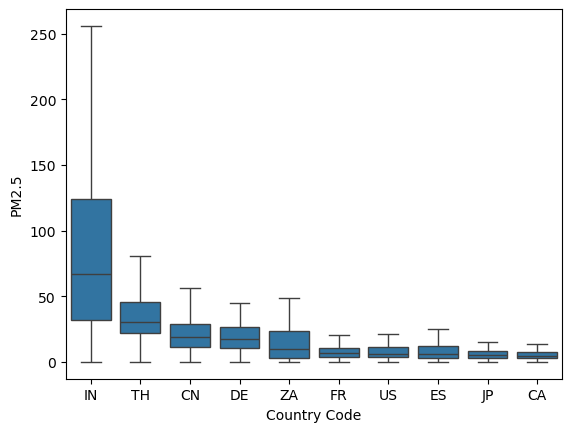

In [82]:
# Boxplot for pollutant levels by country - top 10 countries with more observations ¶
# Creating a boxplot for selected top countries and pollutant
sns.boxplot(data=df_pivot[df_pivot['Country Code'].isin(top_countries)],
            x='Country Code', 
            y=Pollutant,
            showfliers=False,
            order=order[order.isin(top_countries)])

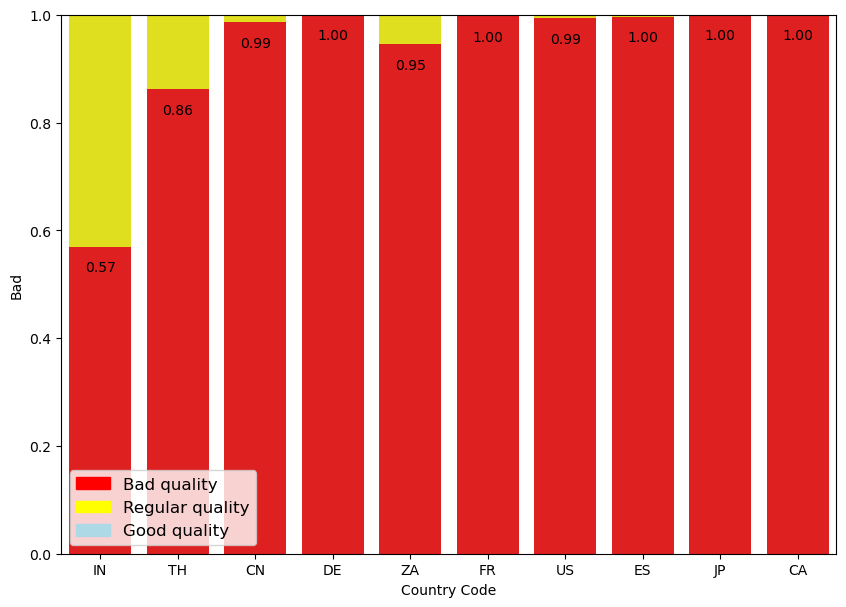

In [83]:
# Set the figure size
plt.figure(figsize=(10,7))

# Create a bar chart for 'Bad' quality
sns.barplot(x="Country Code", y="Bad", data=df_qual, 
            color='red', order=order[order.isin(top_countries)])\
    .bar_label(sns.barplot(x="Country Code", y="Bad", data=df_qual, 
                           color='red', order=order[order.isin(top_countries)])\
               .containers[0], fontsize=10, fmt='%.2f', padding=-20)

# Create a bar chart for 'Regular' quality, stacked on 'Bad' quality
sns.barplot(x="Country Code", y="Regular", data=df_qual, 
            color='yellow', order=order[order.isin(top_countries)], 
            bottom=df_qual['Bad'])

# Create a bar chart for 'Good' quality, stacked on 'Bad' and 'Regular' quality
sns.barplot(x="Country Code", y="Good", data=df_qual, 
            color='lightblue', order=order[order.isin(top_countries)], 
            bottom=df_qual['Bad'] + df_qual['Regular'])
# Add legend
plt.legend(handles=[
    mpatches.Patch(color='red', label='Bad quality'),
    mpatches.Patch(color='yellow', label='Regular quality'),
    mpatches.Patch(color='lightblue', label='Good quality')
], loc='lower left', fontsize=12)

# Show the graph
plt.show()

<Axes: xlabel='Country Code', ylabel='PM2.5'>

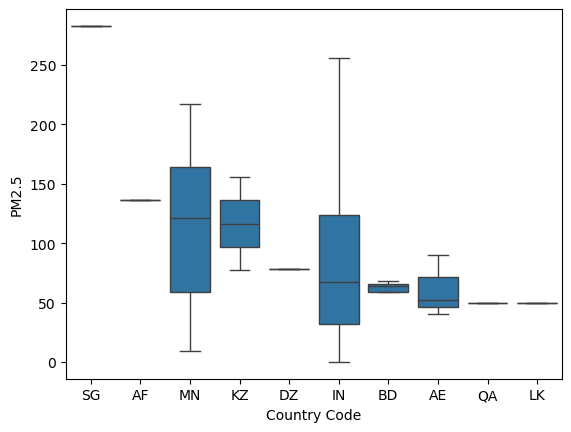

In [87]:
# Boxplot for pollutant levels by country - top 10 countries with the highest median pollution
sns.boxplot(data=df_pivot[df_pivot['Country Code'].isin(order[:10])],  # Filter data for top 10 countries
            x='Country Code',                                         # Set x-axis to country codes
            y=Pollutant,                                              # Set y-axis to pollutant levels
            showfliers=False,                                         # Do not show outliers
            order=order[:10])  

In [88]:
# Count observations for each quality level in each country
df_qual = df_pol.groupby(['Country Code', 'Quality'])['Value_standard'].count().reset_index().rename(columns={'Value_standard': 'Observations'})

# Count total observations for each country
df_total = df_pol.groupby(['Country Code'])['Value_standard'].count().reset_index().rename(columns={'Value_standard': 'Total'})

# Create all combinations of countries and quality levels
df_all = pd.DataFrame({'Country Code': df_pol['Country Code'].drop_duplicates()}).merge(
    pd.DataFrame({'Quality': ['Bad', 'Regular', 'Good']}), how='cross')

# Merge data to calculate share of observations for each quality level
df_qual = df_all.merge(df_qual, how='left', on=['Country Code', 'Quality']).merge(df_total, how='left', on='Country Code')
df_qual['Share'] = (df_qual['Observations'] / df_qual['Total']).fillna(0)

# Filter for top 10 countries and pivot the dataframe
df_qual = df_qual[df_qual['Country Code'].isin(order[:10])].pivot(index='Country Code', columns='Quality', values='Share')

# Reorder columns and reset index
df_qual = df_qual[['Good', 'Regular', 'Bad']].loc[order[:10]].reset_index()


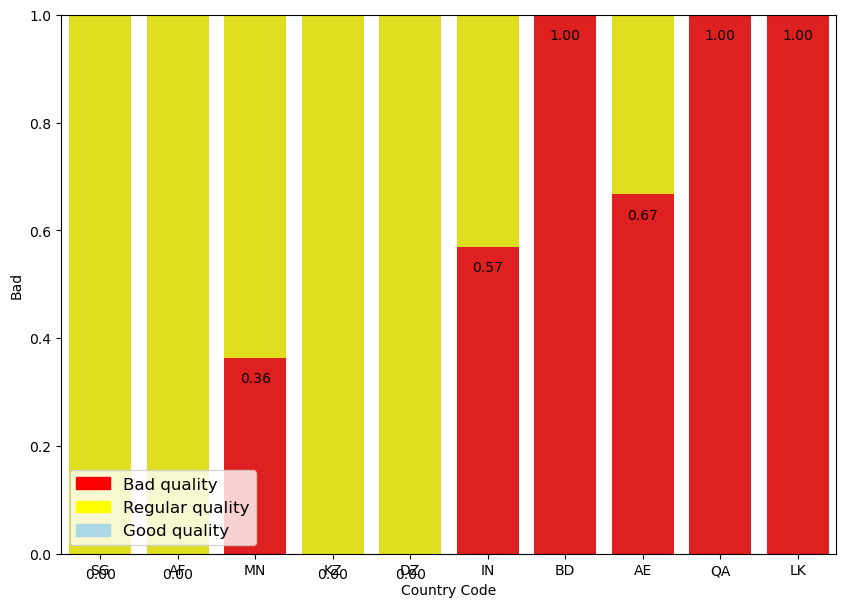

In [89]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Create a bar chart for 'Bad' quality
bar1 = sns.barplot(x="Country Code", y="Bad", data=df_qual, color='red', order=order[:10])
bar1.bar_label(bar1.containers[0], fontsize=10, fmt='%.2f', padding=-20)

# Create a bar chart for 'Regular' quality, stacked on 'Bad' quality
sns.barplot(x="Country Code", y="Regular", data=df_qual, color='yellow', order=order[:10], bottom=df_qual['Bad'])

# Create a bar chart for 'Good' quality, stacked on 'Bad' and 'Regular' quality
sns.barplot(x="Country Code", y="Good", data=df_qual, color='lightblue', order=order[:10], bottom=df_qual['Bad'] + df_qual['Regular'])

# Add legend
plt.legend(handles=[
    mpatches.Patch(color='red', label='Bad quality'),
    mpatches.Patch(color='yellow', label='Regular quality'),
    mpatches.Patch(color='lightblue', label='Good quality')
], loc='lower left', fontsize=12)

# Show the graph
plt.show()


# Map showing the pollution levels for each coordinate: Good, Regular or Bad ¶
You can click a specific marker to see the Coordinates, Location, Value and Date

In [91]:
! pip install folium